In [13]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model

import tarfile
from urllib.request import urlretrieve
import os
from os import listdir
import nltk
from os.path import isfile, join
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import plot_model
import pandas as pd
%matplotlib inline

In [16]:
def read_data(pathToRead, n_lines):
    """ Reading the zip file to extract text """
    docs = []
    i = 0
    onlyfiles = [f for f in listdir(pathToRead) if isfile(join(pathToRead, f))]
    for filename in onlyfiles:
        with open(pathToRead + filename, 'r', encoding='utf-8') as f:
            for row in f:
                file_string = nltk.word_tokenize(row)
                # First token is the movie ID
                docs.append(' '.join(file_string))
                i += 1
                if n_lines and i == n_lines:
                    break
    return docs

docs = read_data('./data/', 3)
print("Read in {} documents".format(len(docs)))
print(docs)

Read in 3 documents
['the dog saw a cat', 'the dog chased the cat', 'the cat climbed a tree']


In [18]:
#Ici on effectue la tokenisation de notre corpus

v_size = 8
tokenizer = Tokenizer(num_words=v_size, oov_token='UNK')
tokenizer.fit_on_texts(docs)


In [1]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
            context_window = sequence[i-window_size: i+window_size+1]
            distances = np.abs(np.arange(-window_size, window_size+1))
            distances[window_size] = 1.0
            nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
            nom[window_size] = 0.0
            if use_weighting:
                cooc_mat[wi, context_window] += nom/distances    # Update element
            else:
                cooc_mat[wi, context_window] += nom
            print(cooc_mat[wi, context_window])
    
    return cooc_mat    

if not generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 2, v_size, False)
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))

print(cooc_mat)

NameError: name 'docs' is not defined

Computing the co-occurence matrix
Computes the co-occurence matrix and save it to the disk can either load the existing matrix or compute a new one by changing generate_cooc variable.

6
[0. 0. 1. 1. 1. 1. 0. 0.]
[1 6 7 2 3 4 5]
[0. 0. 0. 1. 1. 1. 1.]


([<matplotlib.axis.XTick at 0x299acc11c88>,
 <a list of 7 Text xticklabel objects>)

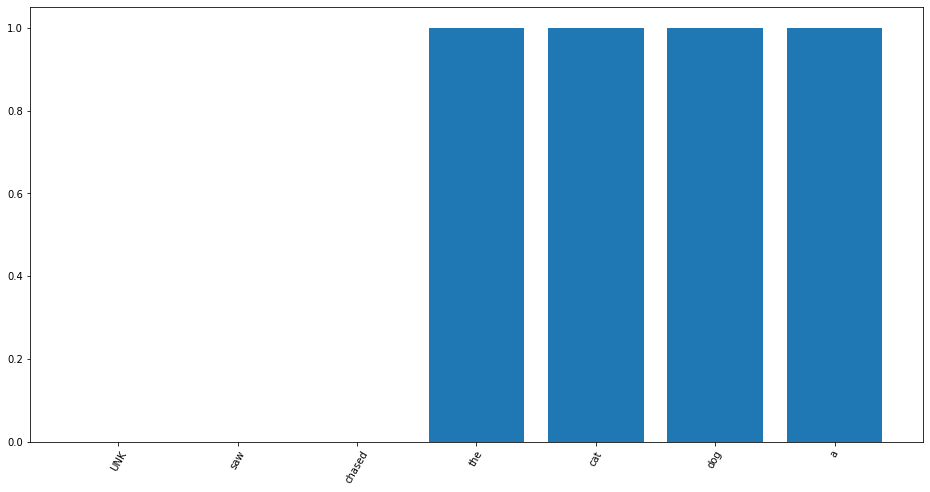

In [43]:
word="saw"
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
print(tokenizer.word_index[word])
cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
print(cooc_vec)
max_ind = np.argsort(cooc_vec)[-7:]
print(max_ind)
print(cooc_vec[max_ind])
plt.figure(figsize=(16,8))
plt.bar(np.arange(0, 7), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 7), labels=[rev_word_index[i] for i in max_ind], rotation=60)

# Definition du modèle de GloVe : 

In [44]:
def create_glove_model(v_size):    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, 96, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, 96, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model


In [45]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 96)        768         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 96)        768         input_2[0][0]                    
______________________________________________________________________________________________

# Lancement et evaluation de GloVe

In [59]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
batch_size =128
copy_docs = list(docs)
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(10):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        print(x_ij)
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [2.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]]
[[2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [2.]
 [1.]
 [2.]
 [1.]
 [1.]]
Loss in epoch 0: 0.08402467394868533
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [2.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]]
[[2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]]
Loss in epoch 1: 0.08383174240589142
[[2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 

# Sauvegarde du modele et des embedings localement

In [48]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'embeddings_w.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model.h5')

RuntimeError: Unable to create link (name already exists)

# Test 

In [58]:
def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(120)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        

valid_words = get_valid_words(docs, 10, tokenizer)
print(valid_words)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w.csv'))
print(embed_mat)
print(words)
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Loading the word embeddings from the disk
Embedding shape: (8, 96)
[[-3.12904340e-02 -2.37072600e-02  1.05774070e-02  7.84370700e-03
  -5.70945370e-02 -3.27894350e-02 -6.20539400e-02  5.33598180e-02
   1.32448920e-02 -5.35469900e-02  2.72486560e-02  4.04965170e-02
   2.28268620e-02 -3.51344870e-02  1.64486800e-02 -5.75118550e-02
  -4.54790100e-02  4.42346200e-03 -1.55392290e-02  1.27150190e-02
   1.07014660e-02 -7.02605250e-02 -1.86458600e-02 -3.14376240e-02
   3.45887430e-02  2.95175650e-02 -7.88096340e-02 -5.90686240e-02
  -4.33370250e-02 -2.83415910e-02 -2.01829410e-02  2.50835160e-02
  -3.33745400e-03 -6.95928200e-03 -2.35212100e-02  6.15609300e-02
  -1.49804600e-02  4.49373160e-02 -3.31103300e-02  2.49636170e-03
  -8.37332460e-02  7.46151430e-03  7.84874200e-02 -4.68258500e-02
  -2.17478130e-02  1.82852610e-02  1.52100360e-02  5.25698800e-03
   6.10628500e-02  1.75771490e-02  1.86252110e-02 -2.08496560e-02
   2.71369000e-02 -2.70481930e-02  1.8359873

D:\IDE\Anaconda\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
